# 雷达数据

## 雷达数据的绘制和上传redis




In [1]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour
from cinrad.visualize import Section
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""
    name = 'nlcmap'
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels/ self.levels.max()
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self._y = np.linspace(self.levmin, self.levmax, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi/self.levmax, alpha)
    
class radar_data:
    def __init__(self):
        self.rs = redis.Redis(host='127.0.0.1', port=6379)
    def to_redis(self,imd):
        if self.rs.get("radar"):
            data = pickle.loads(self.rs.get("radar"))  
            radar_len = len(data['imglist'])
            if radar_len>10:
                data['imglist'] = data['imglist'][-9:]
                data['imglist'].append(imd)
            else:
                data['imglist'].append(imd)
        else:
            imglist = [imd]
            data = {
                "imglist":imglist
            }
        self.rs.set("radar", pickle.dumps(data))       
    def plot_data(self):
#         path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
#         f = cinrad.io.CinradReader(path+'Z_RADR_I_Z9576_20150809120400_O_DOR_SA_CAP.bin.bz2')
        path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
        f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230822032019_O_DOR_SAD_CAP_FMT.bin.bz2')
        tilt_number = 0
        data_radius = 230
        data_dtype = 'REF' # stands for reflectivity
        # 数据加载核心
        ra = f.get_data(tilt_number, data_radius, data_dtype)
        rl = list(f.iter_tilt(230, 'REF'))
        cr = cinrad.calc.quick_cr(rl)
        data = cr.CR
        output = data.interp(latitude=np.linspace(min(data.latitude).data, max(data.latitude).data, 500),longitude = np.linspace(min(data.longitude).data, max(data.longitude).data, 500),method="nearest")
        m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
        ## 颜色 ------
        colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
        levels1 = [20,25,30,35,40,45,50,55,60,65,70,75]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
        contour = plt.contourf(output.longitude, output.latitude, output,cmap=cmaps,levels = levels1)
#         plt.axis('off') 
        geojson = geojsoncontour.contourf_to_geojson(
            contourf=contour,
            ndigits=3,
            unit='dbz'
        )
        self.to_redis(geojson)
        self.to_vcs(rl)
        plt.close()
        return data
    def plot_ppi(self):
        path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
        f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230822032019_O_DOR_SAD_CAP_FMT.bin.bz2')
        v = f.get_data(0,230, 'REF')
        fg =cinrad.calc.GridMapper([v])
        output = fg(0.01)
        colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
        levels1 = [20,25,30,35,40,45,50,55,60,65,70,75]
        cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
        contour = plt.contourf(output.longitude, output.latitude, output.REF,cmap=cmaps,levels = levels1)
        geojson = geojsoncontour.contourf_to_geojson(
            contourf=contour,
            ndigits=3,
            unit='dbz'
        )
        self.to_redis(geojson)
        plt.close()
        return output
    def get_radar(self):
        data = pickle.loads(self.rs.get("radar"))
        return data
    def to_vcs(self,rl):
        vcs = cinrad.calc.VCS(rl)
        data = {
            "vcs":vcs
        }
        self.rs.set("radar_vsc", pickle.dumps(data))
    def get_vcs(self):
        data = pickle.loads(self.rs.get("radar_vsc"))
        return data['vcs']
    def plot_sec(self,start,end):
        fig = plt.figure(figsize=(16, 8))
        fig.set_facecolor('white') 
        vcs = self.get_vcs()
        sec = vcs.get_section(start_cart=(start[0], start[1]), end_cart=(end[0], end[1])) 
        Section(sec)
#         buffer = BytesIO()
#         plt.savefig(buffer,bbox_inches='tight')  
#         plot_img = buffer.getvalue()
#         imb = base64.b64encode(plot_img) 
#         ims = imb.decode()
#         imd = "data:image/png;base64,"+ims
        #plt.close()
#         return imd
        
start=[121.25, 28.2]
end=[121.45, 29.40]
worker = radar_data()
data = worker.plot_data()
#data = worker.get_radar()
# output = worker.plot_ppi()

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/gribapi/__init__.py:25: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.6.0
  "You are running version {}".format(min_recommended_version_str, __version__)
/opt/conda/lib/python3.7/site-packages/cinrad/calc.py:110: RuntimeWarning: All-NaN axis encountered
  cr = np.nanmax(r_data, axis=0)


CPU times: user 53.2 s, sys: 1.51 s, total: 54.8 s
Wall time: 58.3 s


In [6]:
output

<xarray.Dataset>
Dimensions:    (latitude: 416, longitude: 474)
Coordinates:
  * latitude   (latitude) float64 26.55 26.56 26.57 26.58 ... 30.68 30.69 30.7
  * longitude  (longitude) float64 119.2 119.2 119.2 119.2 ... 123.9 123.9 123.9
Data variables:
    REF        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    elevation:        0
    range:            230
    scan_time:        2023-08-22 03:20:19
    site_code:        RADMAP
    site_name:        RADMAP
    tangential_reso:  nan
    task:             VCP21D

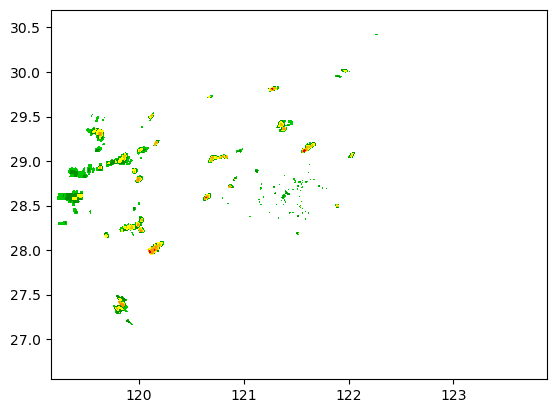

In [7]:
# huitu 

# m = Basemap(llcrnrlon=119.16,llcrnrlat=26.55,urcrnrlon=123.88,urcrnrlat=30.69)
## 颜色 ------
colorslist = ['#00C800','#019000','#FFFF00','#E7C000','#FF9000','#D60000','#C00000','#FF00F0','#780084','#AD90F0','#AE0AF5']# 组合反射率
levels1 = [20,25,30,35,40,45,50,55,60,65,70,75]
cmaps = LinearSegmentedColormap.from_list('mylist',colorslist,N=11)
contour = plt.contourf(output.longitude, output.latitude, output.REF,cmap=cmaps,levels = levels1)

In [ ]:
plt.contourf(output.longitude, output.latitude, output,cmap=cmaps,levels = levels1)

In [18]:

worker.plot_sec(start,end)

TypeError: __init__() got an unexpected keyword argument 'style'

<Figure size 1600x800 with 0 Axes>

# 雷达剖面测试

In [14]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour

lat_point = [28.2,29.40]
lon_point = [121.25,121.45]
path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
rl = [f.get_data(i, 230, 'REF') for i in f.angleindex_r]

vcs = cinrad.calc.VCS(rl)
# pass geographic coordinates (longitude, latitude)

#fig = Section(sec)

CPU times: user 51.4 s, sys: 194 ms, total: 51.6 s
Wall time: 6.08 s


In [12]:
%%time
sec = vcs.get_section(start_cart=(121.25, 28.2), end_cart=(121.45, 29.40)) 

CPU times: user 231 ms, sys: 6.23 ms, total: 237 ms
Wall time: 236 ms


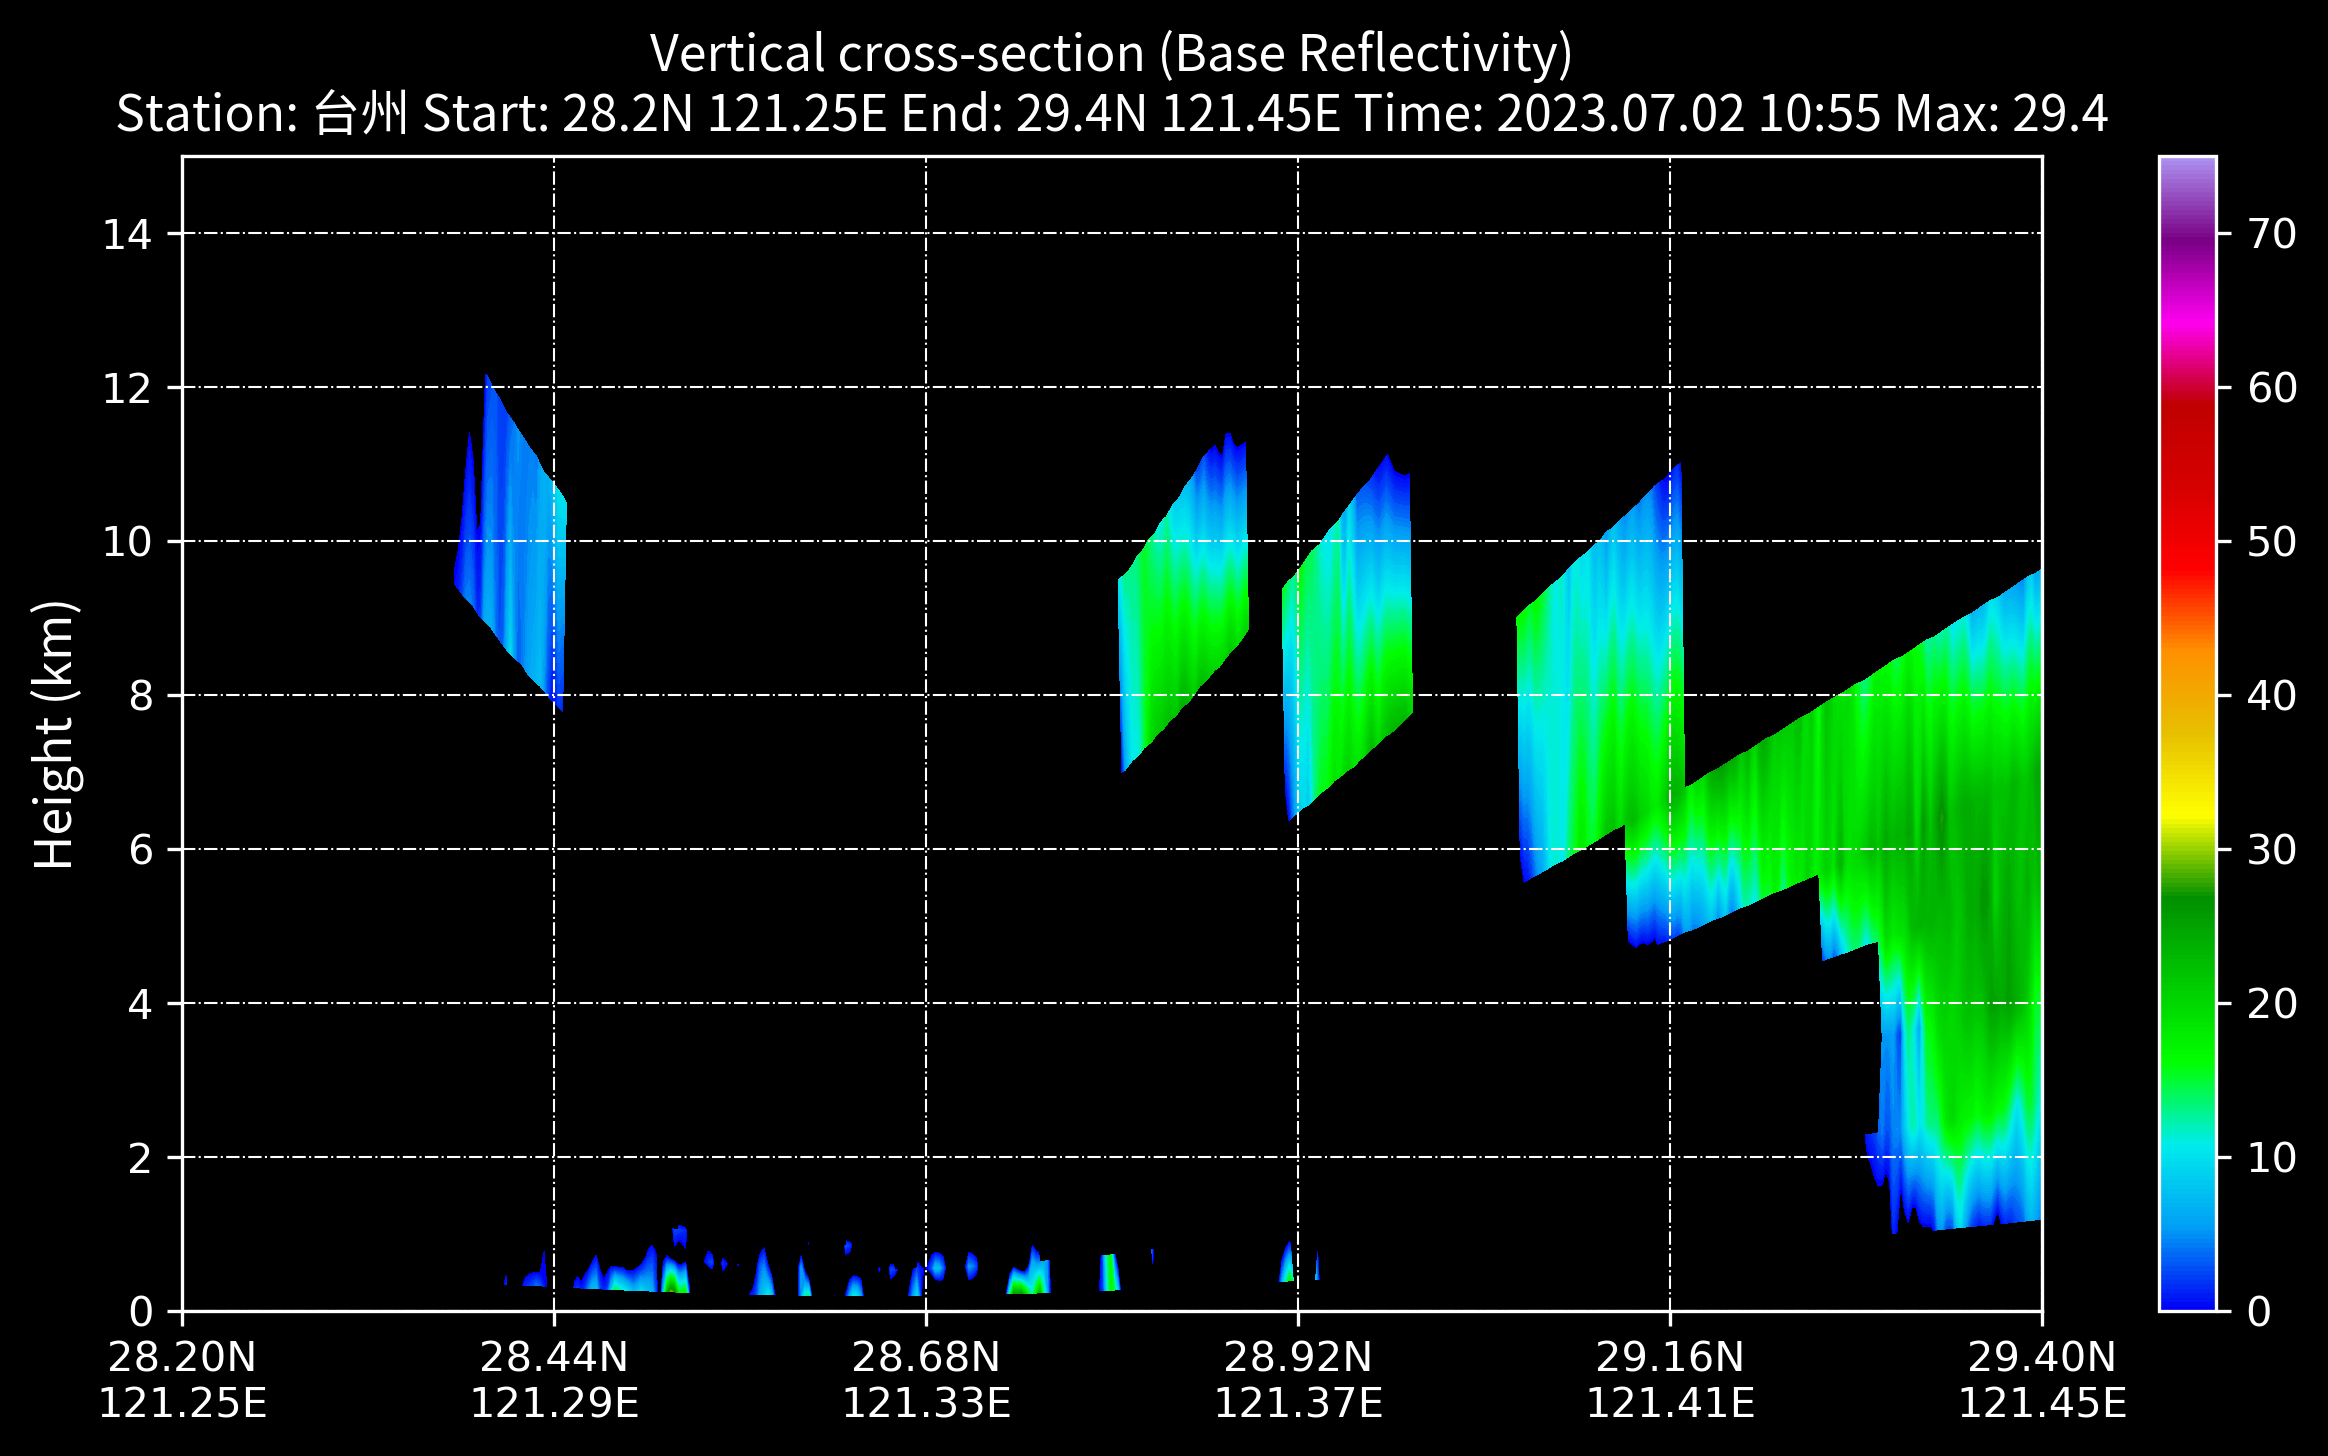

In [13]:
from cinrad.visualize import Section
fig = Section(sec)

In [4]:
f.available_product(0)

['TREF', 'REF', 'ZDR', 'RHO', 'PHI', 'KDP', 'SNRH']

In [21]:
%%time
%matplotlib inline
import pymysql
import pymssql 
import numpy as np
import pandas as pd
import pickle
import redis
import datetime as dtt
import cinrad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from ncmaps import Cmaps
from io import BytesIO
import base64
import json
import geojsoncontour
from cinrad.visualize import Section
lat_point = [28.2,29.40]
lon_point = [121.25,121.45]
path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
rl = [f.get_data(i, 230, 'REF') for i in f.angleindex_r]
# rl = list(f.iter_tilt(230, 'VEL'))
vcs = cinrad.calc.VCS(rl)


CPU times: user 1min 5s, sys: 974 ms, total: 1min 6s
Wall time: 8.28 s


In [23]:
%%time
sec = vcs.get_section(start_cart=(121.25, 28.2), end_cart=(121.45, 29.40)) 
Section(sec)
buffer = BytesIO()
plt.savefig(buffer,bbox_inches='tight')  
plot_img = buffer.getvalue()
imb = base64.b64encode(plot_img) 
ims = imb.decode()
imd = "data:image/png;base64,"+ims
plt.close()

CPU times: user 892 ms, sys: 10 ms, total: 902 ms
Wall time: 900 ms


# 绘制多个数据

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


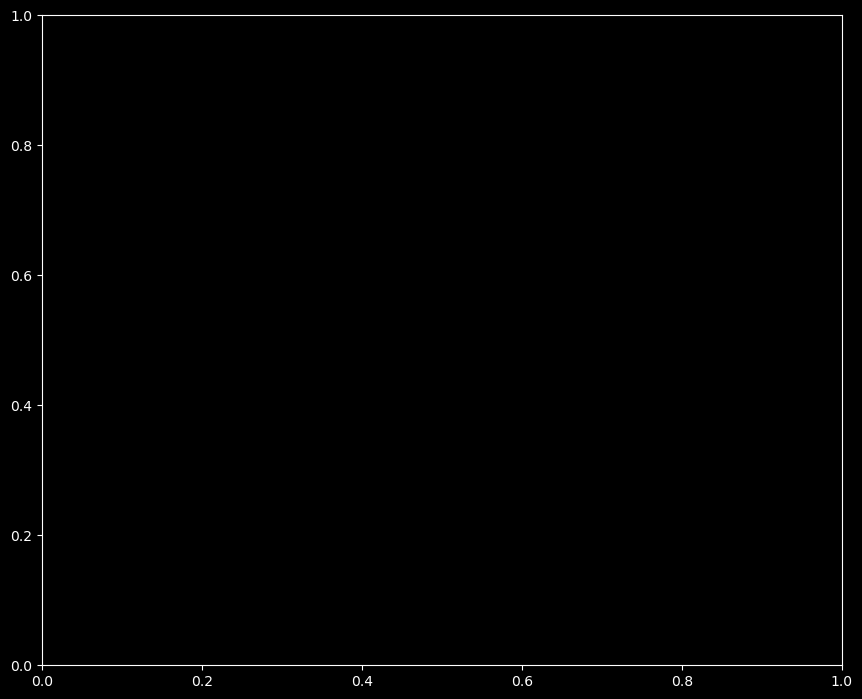

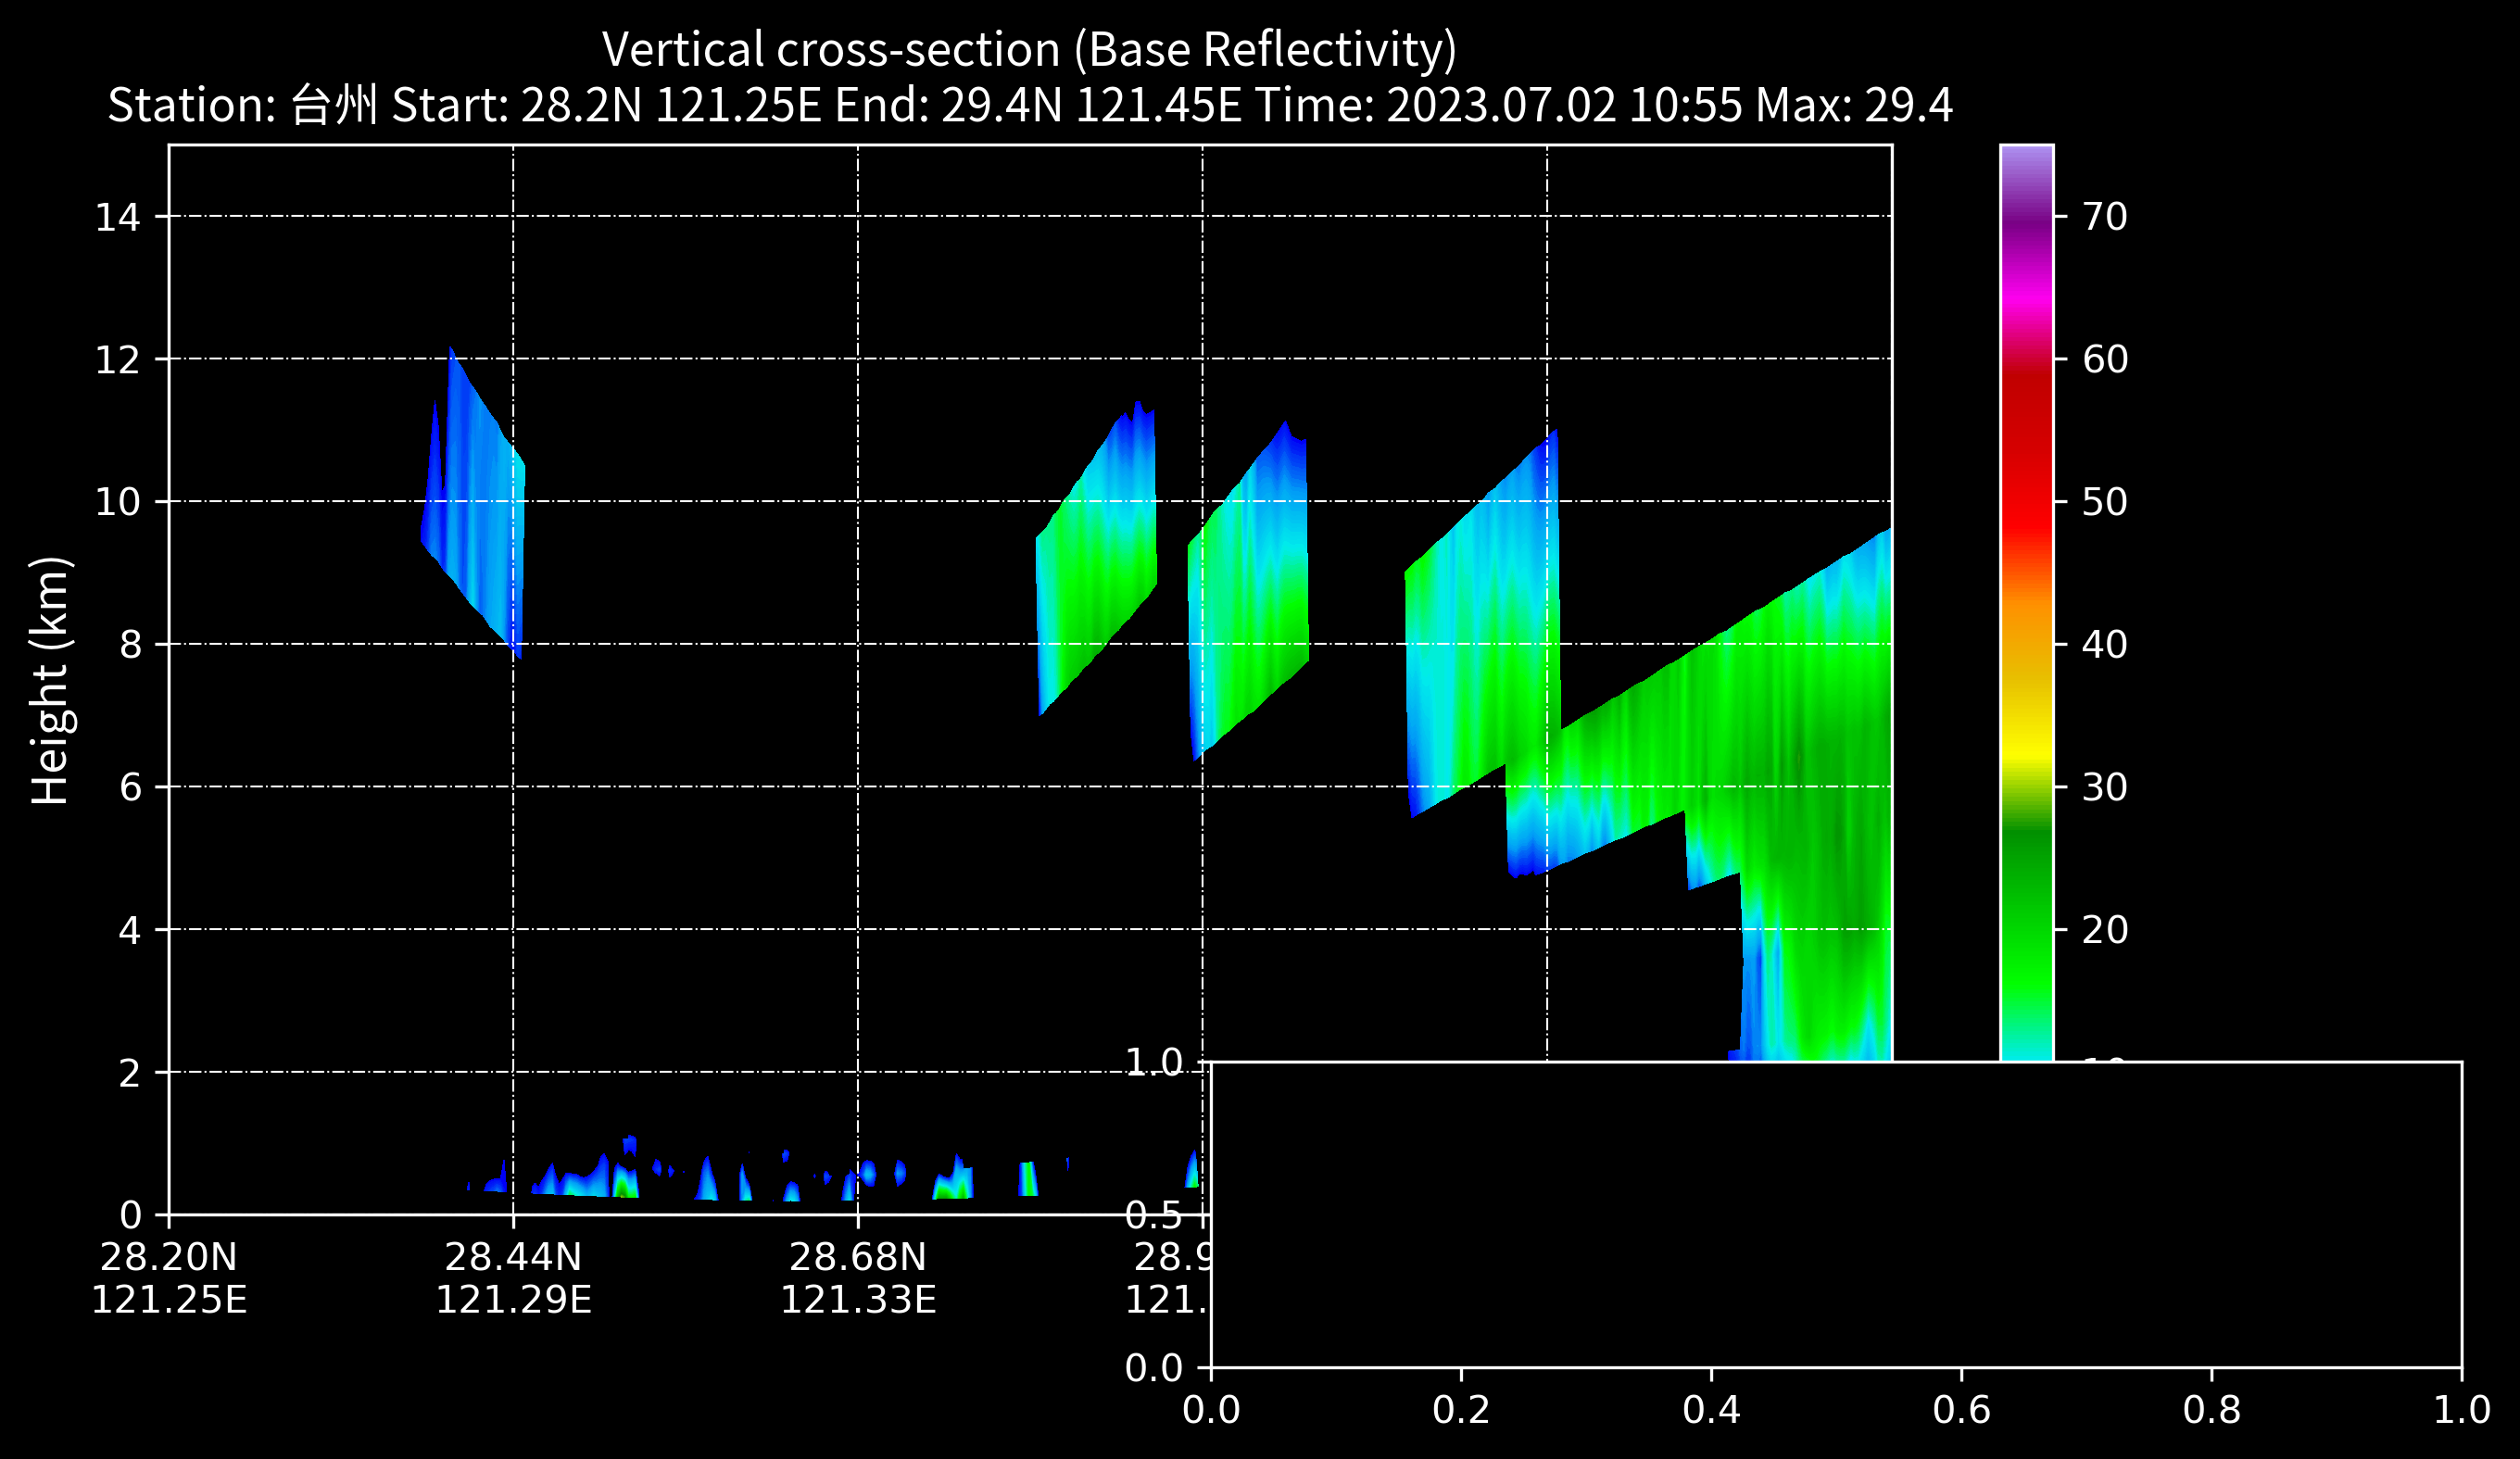

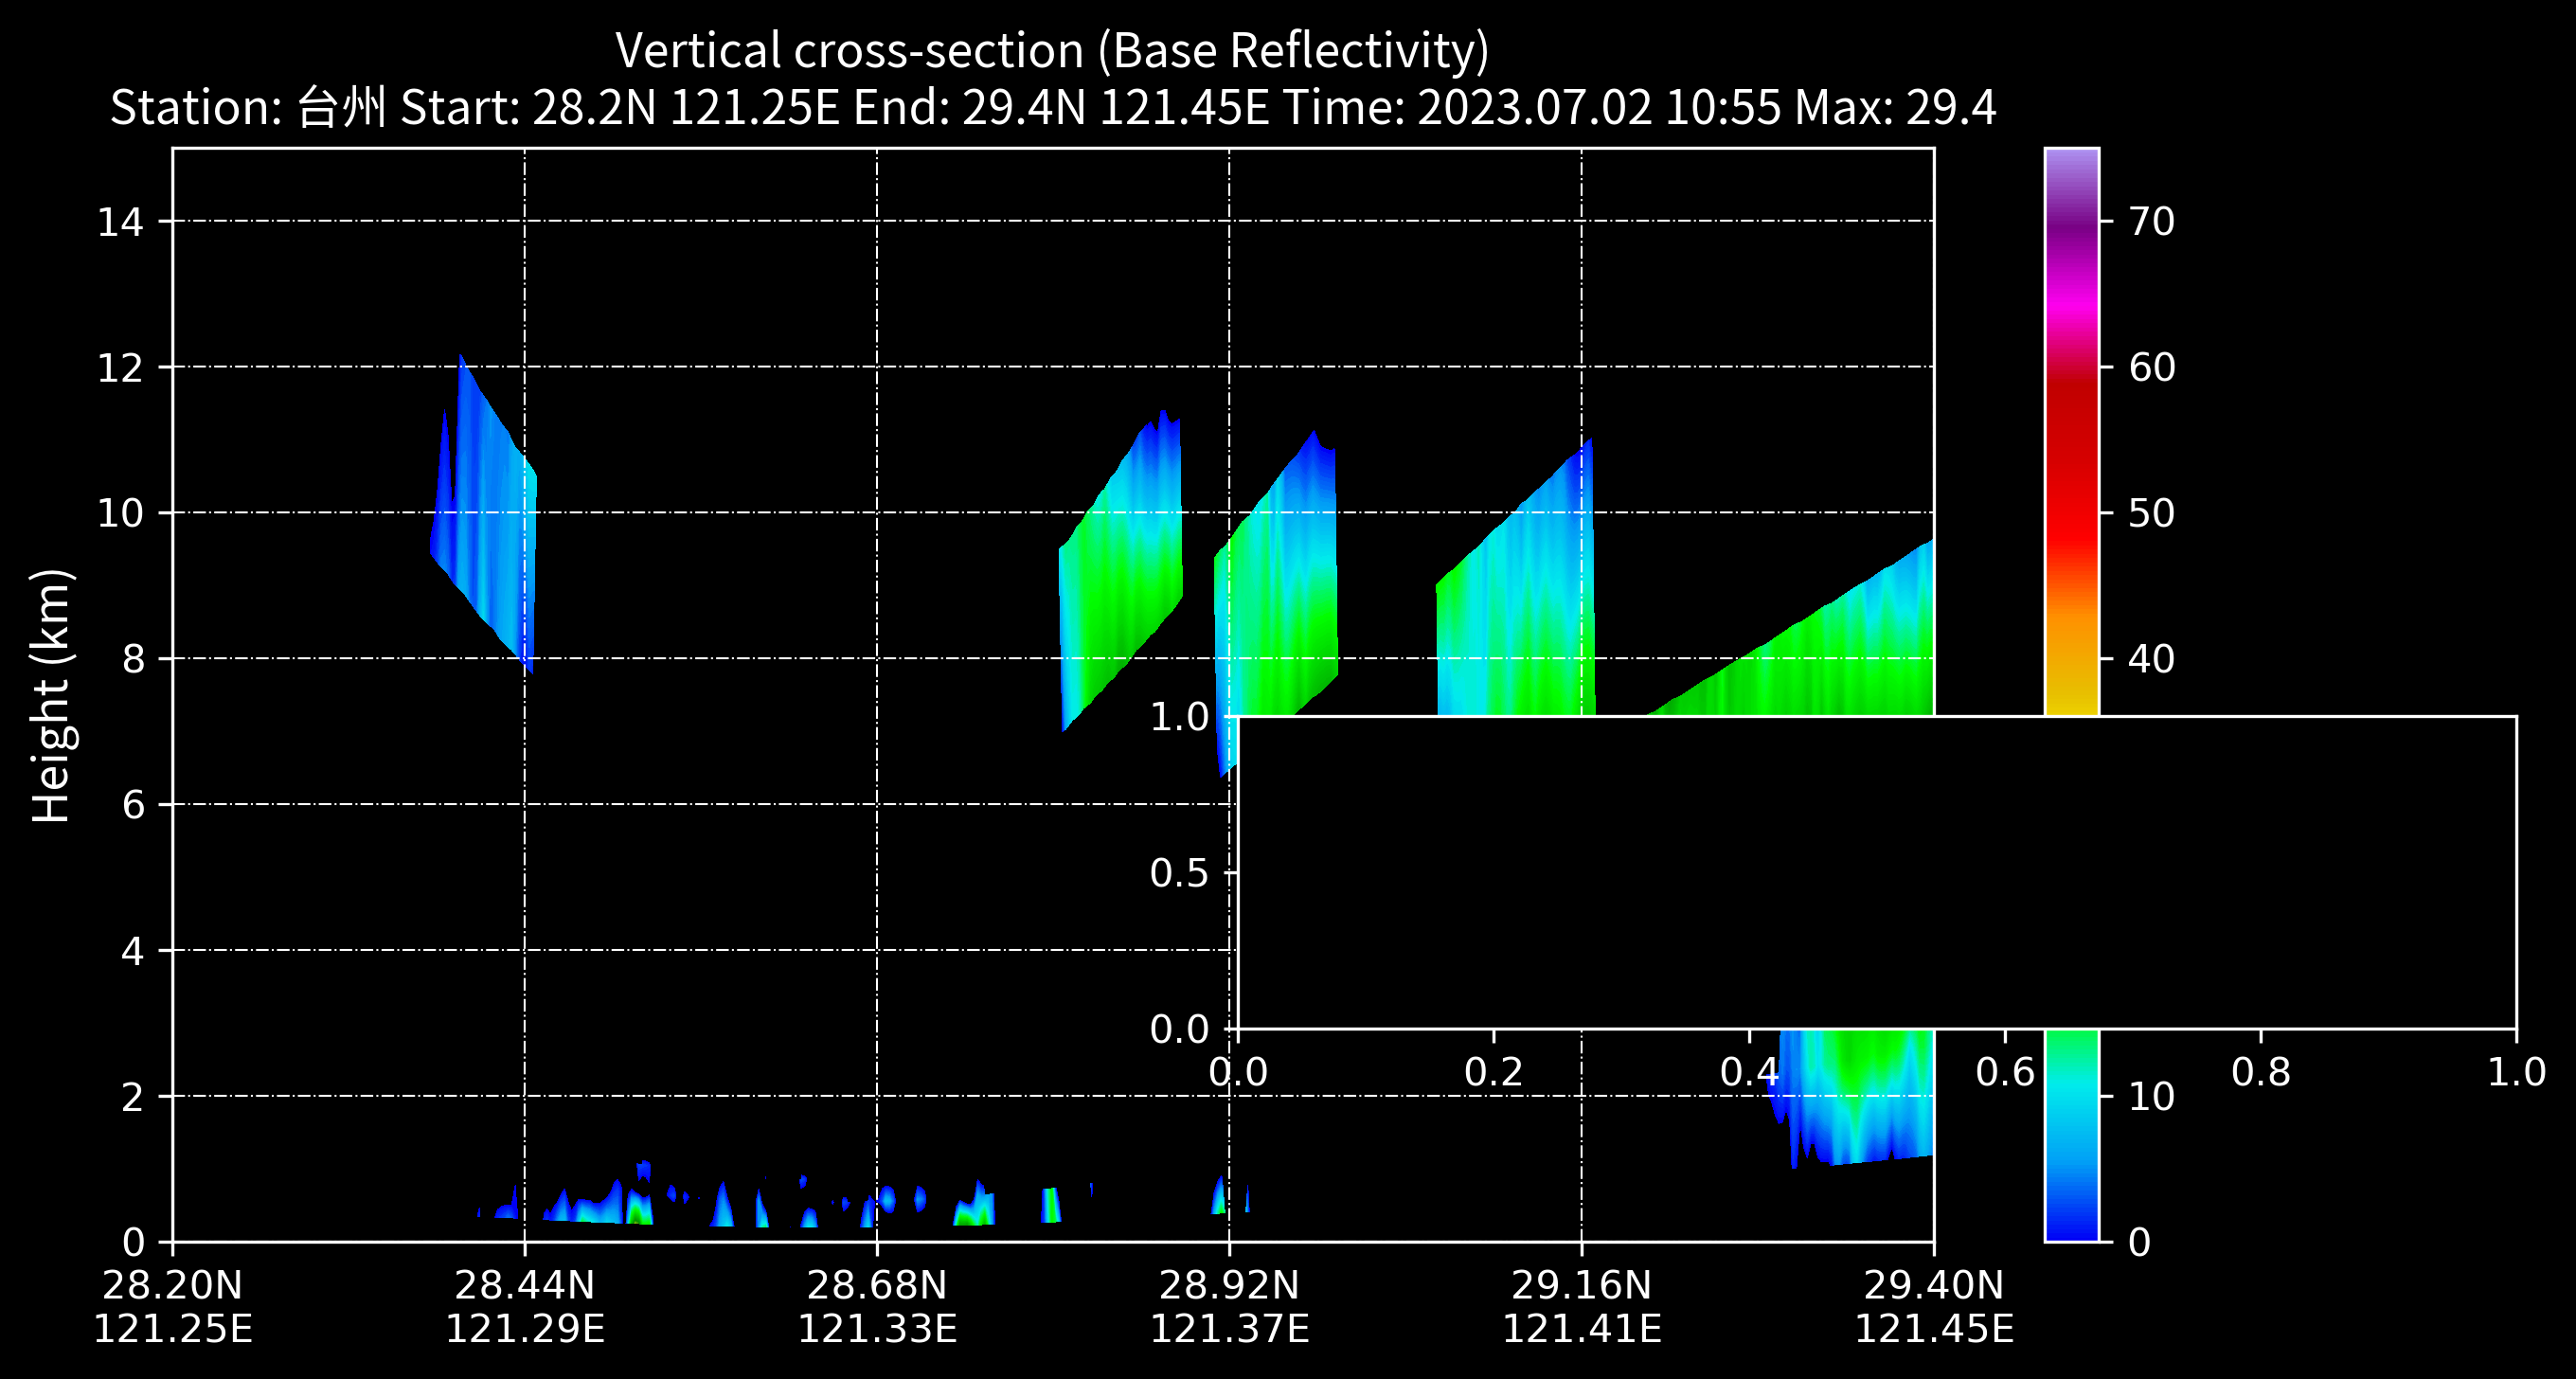

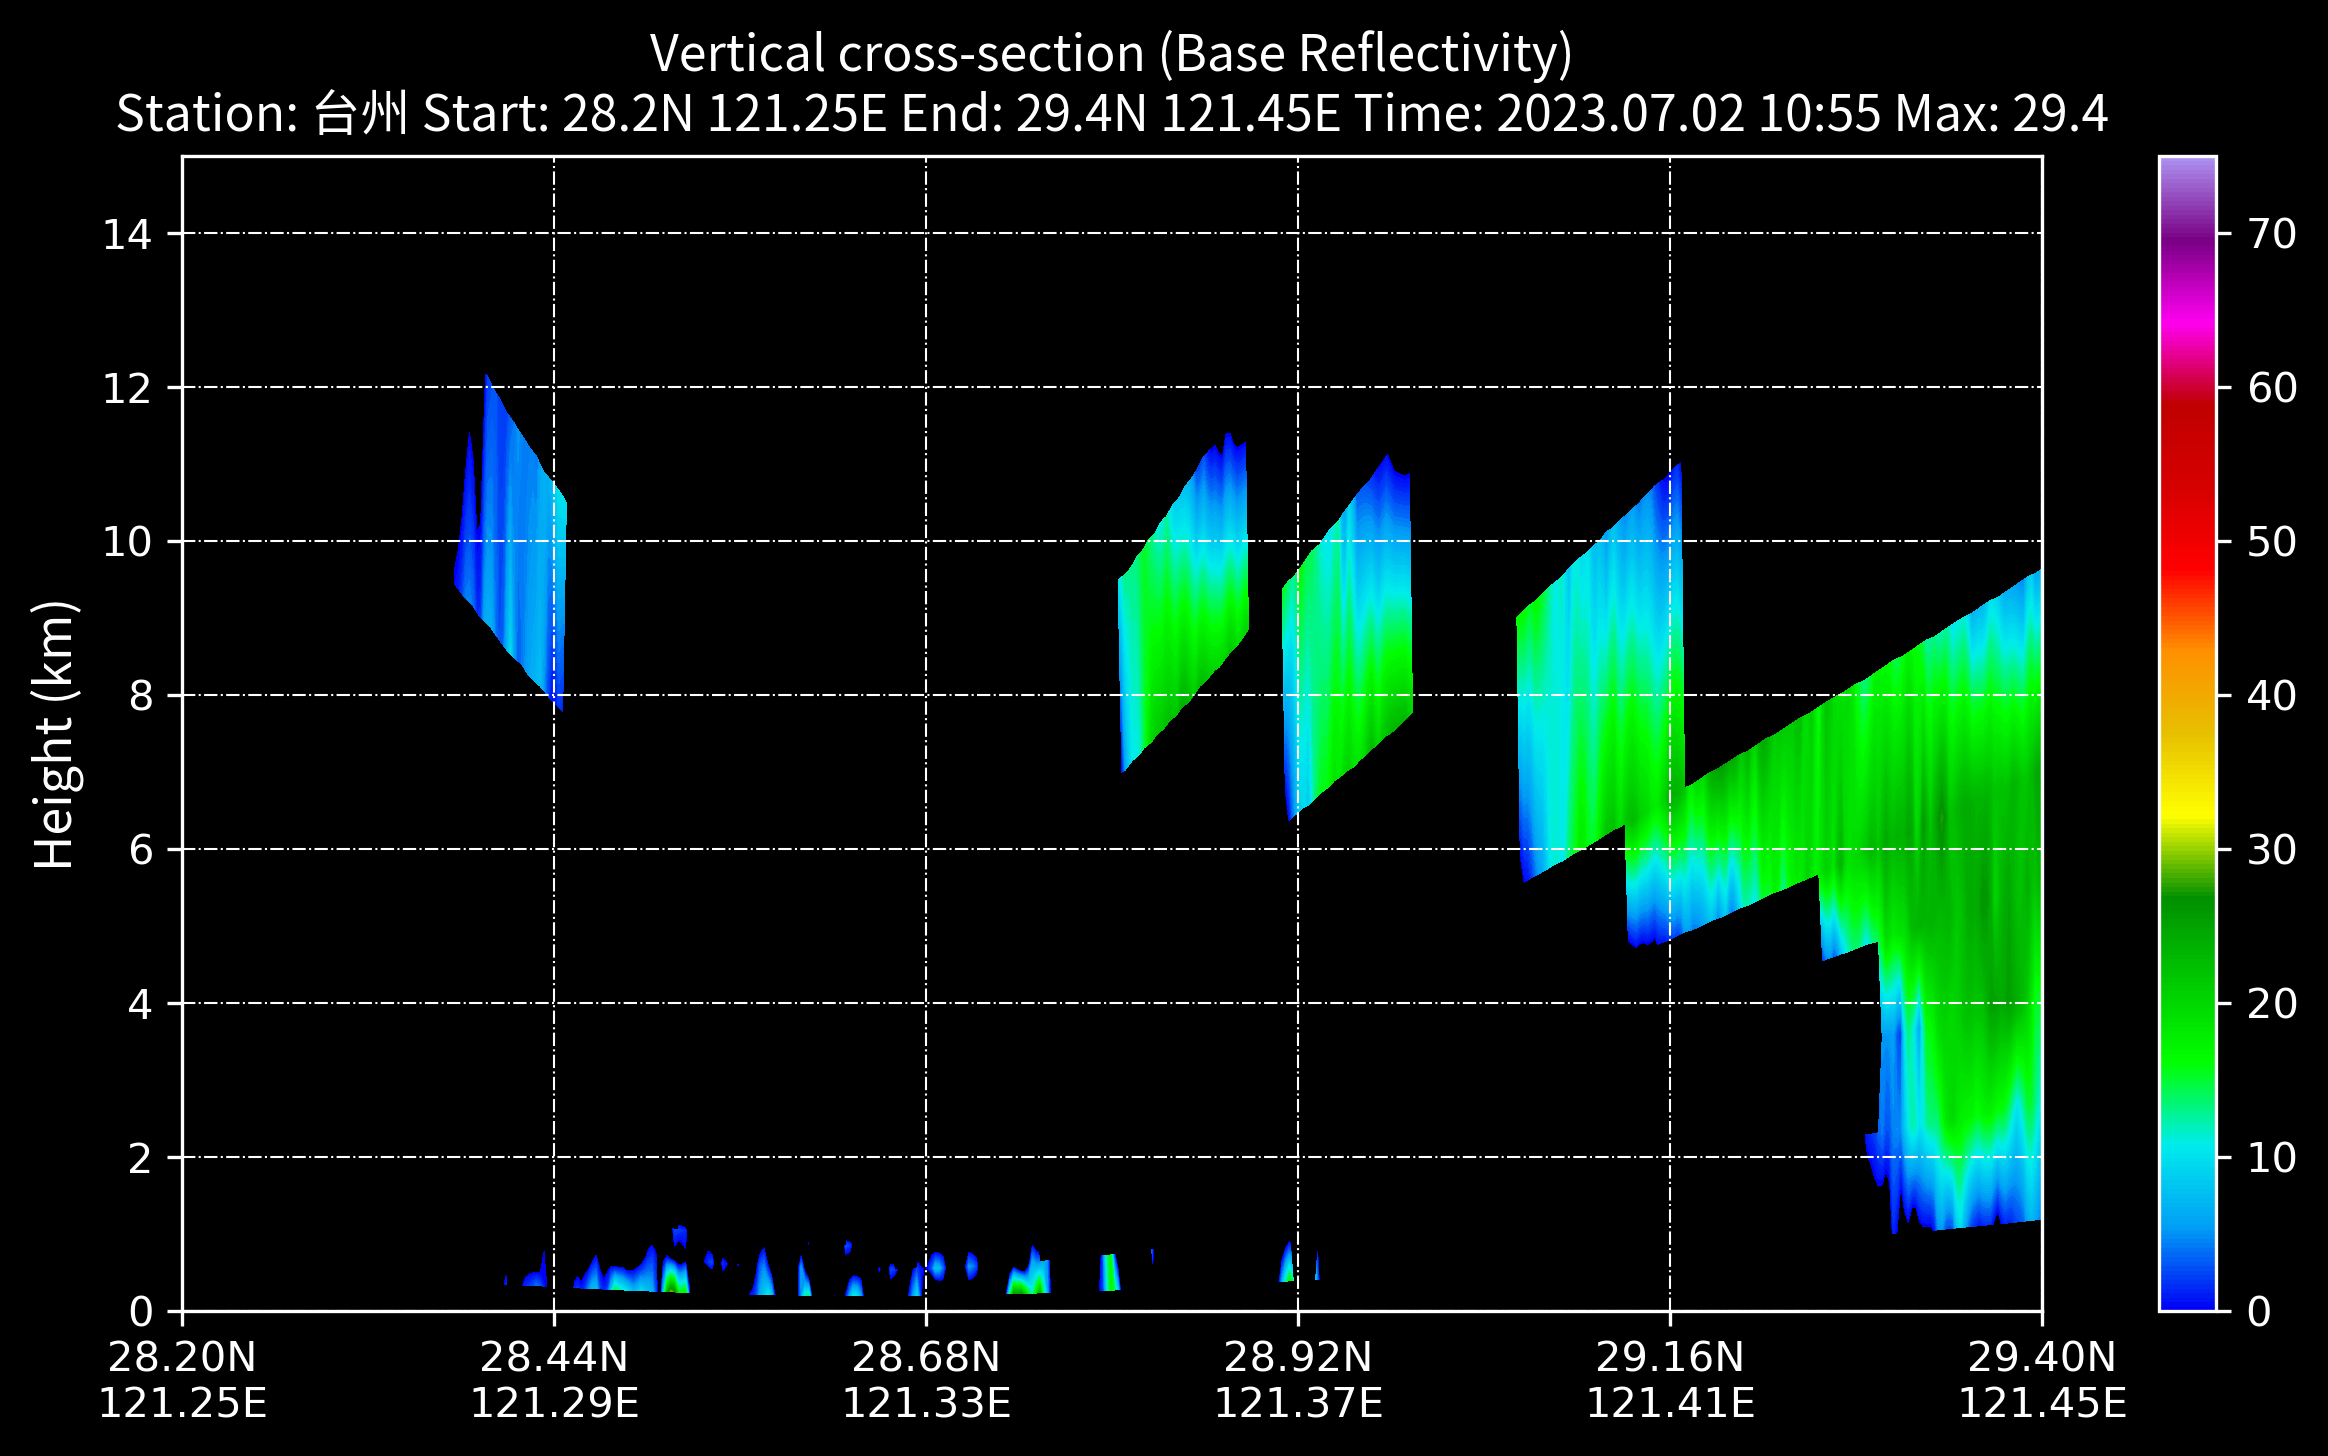

In [27]:
import cinrad
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap


rect1 = [0, 0, 0.4, 0.5] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.5, 0, 0.45, 0.22]
rect3 = [0.5, 0.26, 0.45, 0.22]

###############################
lat_point = [28.2,29.40]
lon_point = [121.25,121.45]
path ="/home/workspace/Data/My_Git/web_met/static/data/downfile/" 
f = cinrad.io.StandardData(path+'Z_RADR_I_Z9576_20230702105550_O_DOR_SAD_CAP_FMT.bin.bz2')
rl = [f.get_data(i, 230, 'REF') for i in f.angleindex_r]
# rl = list(f.iter_tilt(230, 'VEL'))
vcs = cinrad.calc.VCS(rl)
sec = vcs.get_section(start_cart=(121.25, 28.2), end_cart=(121.45, 29.40)) 

# 绘图
fig = plt.figure(figsize=(20, 13),tight_layout=True)
# gs = gridspec.GridSpec(2, 2)
# 绘制第一张图
ax1 = plt.axes(rect1)
Section(sec)
ax2 = plt.axes(rect2)
Section(sec)
ax3 = plt.axes(rect3)
Section(sec)
